In [1]:
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from datasets import BCDataDataset, PointsToGaussianHeatmap, PointsToGaussianHeatmapFast, collate_heatmap_points
from visualization import overlay_heatmap
from training import train
from models import NucleusLocalizationModel, heatmap_weighted_mse_loss

In [2]:
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)


data_root = Path(cfg["paths"]["data_root"])
print(data_root)

/home/yeldos/Istanbul/obsidian_vault/work_AITU/IHC/DATASETS/BCData


In [3]:
heatmap_generator = PointsToGaussianHeatmap(out_hw=(160,160), in_hw=(640,640), sigma=2.0)
heatmap_generator_fast = PointsToGaussianHeatmapFast(out_hw=(160,160), in_hw=(640,640), sigma=2.0, truncate_sigma=5.0)

In [4]:
dataset = BCDataDataset(root = data_root,
                        split="train",
                        target_transform = heatmap_generator)

dataset_fast = BCDataDataset(root = data_root,
                        split="train",
                        target_transform = heatmap_generator_fast)


In [5]:
train_loader = DataLoader(
    dataset,
    batch_size=6,        # choose based on GPU memory (640×640 images are large)
    shuffle=True,
    num_workers=4,       # use 0 if debugging
    pin_memory=True,     # recommended when using GPU
    drop_last=True,       # optional, useful for BatchNorm
    collate_fn = collate_heatmap_points
)

In [6]:
model = NucleusLocalizationModel()
device = 'cuda'

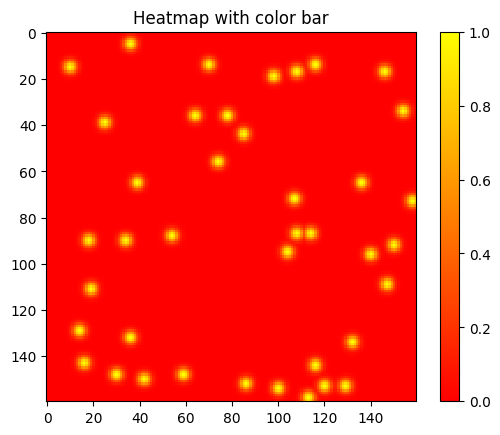

torch.Size([3, 640, 640])
torch.Size([1, 3, 640, 640])


In [7]:
forplot_img, forplot_heatmap, forplot_points = dataset.__getitem__(1)
plt.imshow(forplot_heatmap[0, :,:], cmap='autumn', interpolation='nearest')
plt.colorbar()
plt.title("Heatmap with color bar")
plt.show()

print(forplot_img.shape)
forplot_img = forplot_img.unsqueeze(0)
print(forplot_img.shape)

training start


  0%|          | 0/1 [00:00<?, ?it/s]

epoch: 0


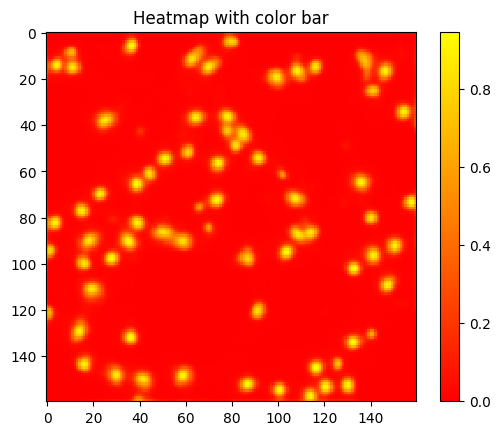

100%|██████████| 1/1 [01:33<00:00, 93.66s/it]

training done


In [8]:
losses = train(model=model, num_epochs=1, train_loader=train_loader, test_loader=None, loss_function=heatmap_weighted_mse_loss, forplot_img=forplot_img)